In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries
import pandas as pd
import os
from shutil import unpack_archive
pd.set_option("display.max_columns", 100)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Load Data

In [ ]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/content/drive/MyDrive/Learning/DTS/Task/DemoDay/Bahasa Isyarat Indo.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

<BarContainer object of 26 artists>

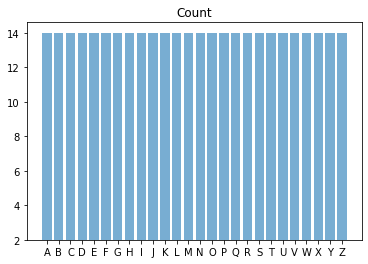

In [ ]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('/tmp/Citra BISINDO/'+az, f)) for f in os.listdir('/tmp/Citra BISINDO/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

## Data Preprocessing

In [ ]:
datagen = ImageDataGenerator(
                    rotation_range =15, 
                    width_shift_range = 0.2, 
                    height_shift_range = 0.2,  
                    shear_range=0.2, 
                    zoom_range=0.2, 
                    fill_mode = 'nearest', 
                    brightness_range=[0.5, 1.5]
) 

In [ ]:
from tqdm import tqdm

In [ ]:
for folder in alphabets:
  for f in os.listdir('/tmp/Citra BISINDO/'+folder):
    filename='/tmp/Citra BISINDO/'+folder+'/'+f

    img = load_img(filename)
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate 5 new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                      save_to_dir ='/tmp/Citra BISINDO/'+folder,  
                      save_prefix ='aug', save_format ='jpg'):
        i += 1
        if i > 5: 
            break

### Checkpoint

In [ ]:
!cp -r /tmp/Citra\ BISINDO/ /content/drive/MyDrive/Learning/DTS/Task/DemoDay/

<BarContainer object of 26 artists>

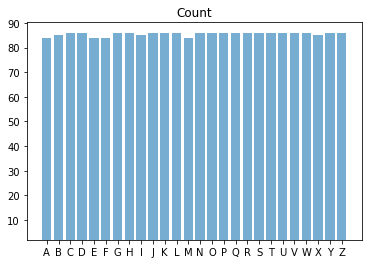

In [ ]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('/tmp/Citra BISINDO/'+az, f)) for f in os.listdir('/tmp/Citra BISINDO/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

In [ ]:
splitfolders.ratio('/tmp/Citra BISINDO/', output="/content/split", seed=1, ratio=(.8, .2))
base_dir = '/content/split/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'val')

Copying files: 2173 files [00:00, 2830.85 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    #other augmentations have been done before to handle lack of data
                )

valid_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    # color_mode = 'grayscale',
                                                    target_size = (150, 150))
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = valid_datagen.flow_from_directory(valid_dir,
                                                         batch_size = 20,
                                                         class_mode = 'categorical',
                                                        #  color_mode = 'grayscale',
                                                         target_size = (150, 150))

Found 1731 images belonging to 26 classes.
Found 442 images belonging to 26 classes.


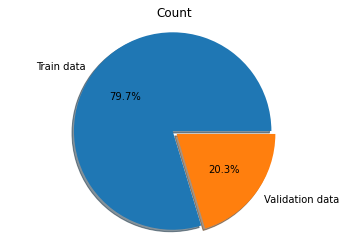

In [ ]:
labels = ['Train data', 'Validation data']
values = [len(train_generator.filenames), len(validation_generator.filenames)]
plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0, 0.05))
plt.axis('equal')
plt.title('Count')
plt.show()

## Training Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(150, 150 ,3) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.20))

model.add(Dense(26, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

In [ ]:
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
best_model_path = 'model.h5'
chp_callback = ModelCheckpoint(best_model_path,
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=5)
rdc_callback = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 factor=0.5,
                                 min_lr=0.001,
                                 verbose=5)
callbacks_list = [chp_callback, rdc_callback]

In [ ]:
# Fit model
batch_size = 64
history=model.fit(
      train_generator,
      steps_per_epoch=len(train_generator.filenames) // batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=len(validation_generator.filenames) // batch_size,
      callbacks=callbacks_list
      )

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 3.2699 - accuracy: 0.0389
Epoch 1: val_accuracy improved from -inf to 0.03333, saving model to model.h5
27/27 [==============================] - 23s 840ms/step - loss: 3.2699 - accuracy: 0.0389 - val_loss: 3.2584 - val_accuracy: 0.0333 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 3.2583 - accuracy: 0.0500
Epoch 2: val_accuracy improved from 0.03333 to 0.05000, saving model to model.h5
27/27 [==============================] - 17s 639ms/step - loss: 3.2583 - accuracy: 0.0500 - val_loss: 3.2565 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 3.2451 - accuracy: 0.0648
Epoch 3: val_accuracy improved from 0.05000 to 0.08333, saving model to model.h5
27/27 [==============================] - 17s 653ms/step - loss: 3.2451 - accuracy: 0.0648 - val_loss: 3.1443 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 4/50
27/27 [=========================

## Evaluate Model

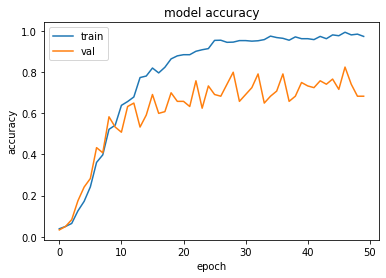

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

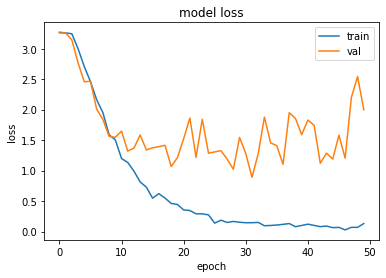

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
!cp /content/model.h5 /content/drive/MyDrive/Learning/DTS/Task/DemoDay/model.h5

In [ ]:
!cp /content/model.json /content/drive/MyDrive/Learning/DTS/Task/DemoDay/model.json